# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy import stats  
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

<div style="border: 2px solid black; border-radius: 20px; padding: 15px 25px; display: inline-block;">
    
##### ✅ Структура кода
    
---
    
⚠️ Правильно, что разделяешь импорт от основного кода, осталось перенести все импорты библиотек в одну ячейку. Это соответствует стилю PEP 8 и делает код более структурированным и понятным.

Это помогает:
- Сразу видеть, какие библиотеки используются в проекте.
- Избежать дублирования импортов в разных частях кода.
- Облегчить отладку и переносимость проекта.
    
Подробнее о PEP 8 можно прочитать в статье [*PEP 8 - руководство по написанию кода на Python*](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html).    
    
---
    
💬 Спасибо! Поправила.
    
---
    
✅ Супер! Придерживайся этого стандарта и в будущем.    

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

In [3]:
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [4]:
# пользователь с мах числом сессий
most_active_user = sessions_history['user_id'].value_counts().idxmax()

user_sessions = sessions_history[sessions_history['user_id'] == most_active_user]

# Выводим все данные для данного пользователя
display(user_sessions)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [5]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


In [6]:
#столбец  session_date имеет тип данных обьект. Приведен к типу данных дата
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

In [7]:
#проверим данные
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  object        
 4   install_date       435924 non-null  object        
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 33.3+ MB


In [8]:
# Агрегация данных
user_unique = sessions_history.groupby('session_date').agg(
    unique_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: (x == 1).sum())
).reset_index()

# Вывод результата
print(user_unique.head())

  session_date  unique_users  registered_users
0   2025-08-11          3919               169
1   2025-08-12          6056               336
2   2025-08-13          8489               464
3   2025-08-14         10321               625
4   2025-08-15         14065               840


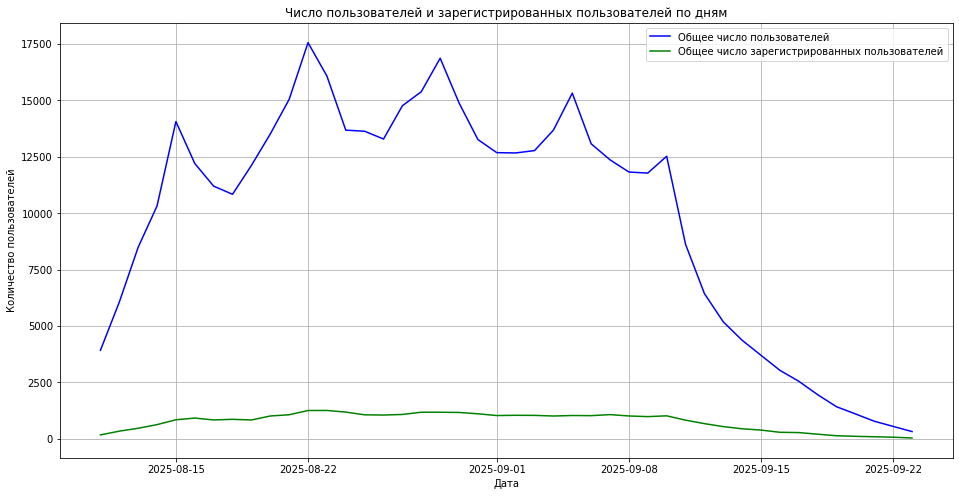

In [9]:
# Построение графиков
plt.figure(figsize=(16, 8))
plt.plot(user_unique['session_date'], user_unique['unique_users'], label='Общее число пользователей', color='blue')
plt.plot(user_unique['session_date'], user_unique['registered_users'], label='Общее число зарегистрированных пользователей', color='green')
plt.title('Число пользователей и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()
plt.show()

ОБщее число зарегистрированных пользователей практически не меняется. Отмечается рост в период с 15.08.2025 по 15.09.2025. Далее 22.09.2025 количество становится на первоначальном уровне, на уровне15.08.2025

In [10]:
# Расчет доли зарегистрированных пользователей
user_unique['registered_dola'] = user_unique['registered_users'] / user_unique['unique_users']

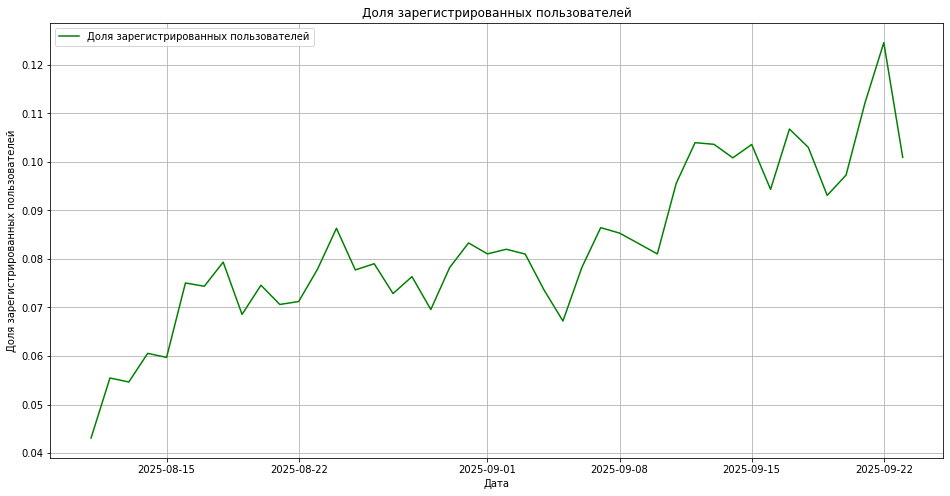

In [11]:
# Построение графика
plt.figure(figsize=(16, 8))
plt.plot(user_unique['session_date'], user_unique['registered_dola'], label='Доля зарегистрированных пользователей', color='green')
plt.title('Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.legend()
plt.grid()
plt.show()

На графике наглядно прослуживается рост лоли зарегистроированных пользователей от общего числа пользователей

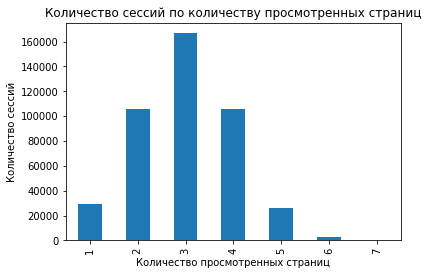

In [12]:
# Подсчет количества сессий для каждого значения количества просмотренных страниц
page_counts = sessions_history['page_counter'].value_counts()

# Сортировка по индексу (количеству страниц)
page_counts_sorted = page_counts.sort_index()

# Построение графика
page_counts_sorted.plot.bar()
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.title('Количество сессий по количеству просмотренных страниц')
plt.show()

максимально просмотрено 3 страницы, более 160000. На втором месте по 2 и по 4 страницы. Количество просмотров практически на одном уровне: 100000. 

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

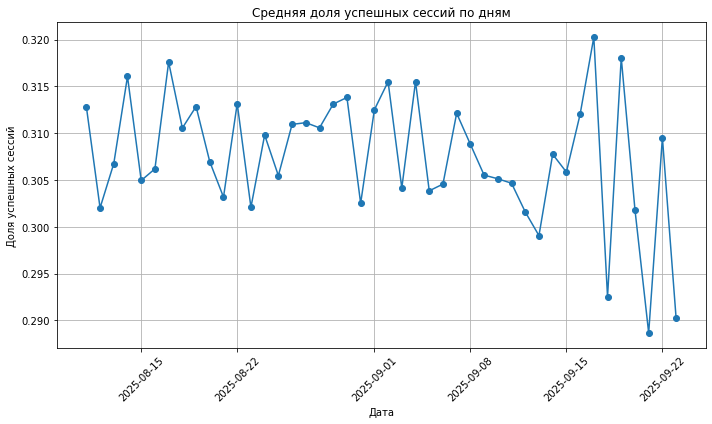

In [13]:
# Создание столбца good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Преобразование столбца session_date в формат даты
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Группировка по дате и расчет средней доли успешных сессий
daily_success_rate = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Переименуем столбцы для удобства
daily_success_rate.columns = ['session_date', 'success_rate']

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(daily_success_rate['session_date'], daily_success_rate['success_rate'], marker='o')
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

График со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения показывает пикообразное изменение показателя.
Обращает внимание спад среднего значения успешных сеесий через месяц после наблюденя. Если в начале периода отмечаются средние значения в пределах 0,303-0,316. то 18.09.2025 снижение достигло 0,29, а 21.09.2025, 23.09.2025 опустилось ниже 0,290. Хотя в период с 18.09.2025по 23.09.2025 наблюдается значимые скачки показателя. От максимального (17.09.2025 - 0,320) до минимального (21.09.2025 - менее 0,290)

In [14]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [15]:
# Вычисляем количество уникальных пользователей в день
unique_users_per_day = sessions_history.groupby(sessions_history['session_date'].dt.date)['user_id'].nunique()

# Вычисляем среднее количество уникальных пользователей в день
avg_daily_users = round(unique_users_per_day.mean(), 2)

# Учитываем обе группы
sample_size = avg_daily_users * 2

# Выводим результат
print(f"Среднее количество уникальных пользователей в день: {avg_daily_users}")
print(f"Размер выборки с учетом обеих групп: {sample_size}")

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size *2/ avg_daily_users)
print(f"Длительность теста: {test_duration}")

Среднее количество уникальных пользователей в день: 9907.36
Размер выборки с учетом обеих групп: 19814.72
Длительность теста: 4


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [16]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
print(sessions_test_part)

               user_id        session_id session_date     session_start_ts  \
0     3404844B53442747  B4901323BD537E45   2025-10-14  2025-10-14 19:28:49   
1     3A2BF4D364E62D89  216FC619308F8788   2025-10-14  2025-10-14 21:11:04   
2     79CDAE11E32B1597  EDFCE4AC1A504074   2025-10-14  2025-10-14 21:44:03   
3     D6AF8D78297A931F  CF0AC0EEDE92C690   2025-10-14  2025-10-14 19:07:55   
4     37E0CE723AE568E0  2E6ED45E8C86C4E9   2025-10-14  2025-10-14 15:39:44   
...                ...               ...          ...                  ...   
3125  02A3BA5F727BC3C9  7D4427384463A16E   2025-10-14  2025-10-14 14:52:26   
3126  A7E51F39427F03A5  290910138655DD03   2025-10-14  2025-10-14 19:15:18   
3127  78DDBD077D61EEDB  C10E073BFF1FAF0C   2025-10-14  2025-10-14 16:07:20   
3128  B44E0A30E8ED1AFC  7B404F7021711E5D   2025-10-14  2025-10-14 17:41:01   
3129  C9F3E29E5168D642  A42ED6D173E5EE2D   2025-10-14  2025-10-14 19:18:11   

     install_date  session_number  registration_flag  page_coun

,session_date,test_group,user_id
0,2025-10-14,A,1477
1,2025-10-14,B,1466


'Количество уникальных пользователей в группе A: 1477'

'Количество уникальных пользователей в группе B: 1466'

'Процентная разница в количестве пользователей между группами A и B: 0.74%'

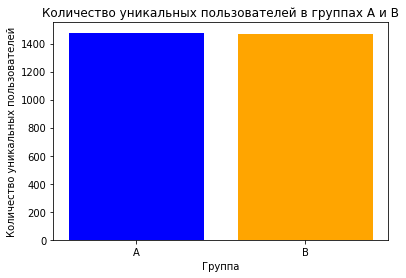

In [17]:
# Рассчитываем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
unique_users = sessions_test_part.groupby(['session_date', 'test_group'])['user_id'].nunique().reset_index()
display(unique_users)

# Рассчитываем процентную разницу между группами A и B
day_data = unique_users[unique_users['session_date'] == unique_users['session_date'].unique()[0]]

# Получаем количество уникальных пользователей в каждой группе
users_A = day_data[day_data['test_group'] == 'A']['user_id'].values[0]
users_B = day_data[day_data['test_group'] == 'B']['user_id'].values[0]

# Рассчитываем процентную разницу
percentage_difference = 100 * abs(users_A - users_B) / users_A

# Выводим результат
display(f"Количество уникальных пользователей в группе A: {users_A}")
display(f"Количество уникальных пользователей в группе B: {users_B}")
display(f"Процентная разница в количестве пользователей между группами A и B: {percentage_difference:.2f}%")

# Визуализация
plt.bar(day_data['test_group'], day_data['user_id'], color=['blue', 'orange'])
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.xticks(rotation=0)
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [18]:
# Получаем уникальных пользователей для каждой группы
unique_users_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique()
unique_users_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique()

# Находим пересечение пользователей в обеих группах
common_users = set(unique_users_A).intersection(set(unique_users_B))

# Рассчитываем количество пользователей, которые попали в обе группы
num_common_users = len(common_users)

# Выводим результат
if num_common_users > 0:
    print(f"Количество пользователей, которые попали в обе группы: {num_common_users}")
else:
    print("Пользователи не пересекаются между группами A и B.")

Пользователи не пересекаются между группами A и B.


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


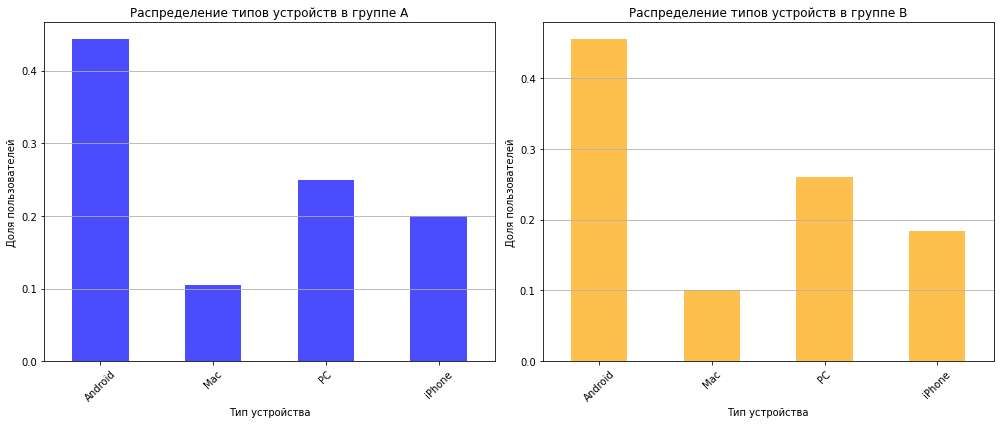

In [19]:
# Группируем данные по device и test_group, считаем количество уникальных пользователей
device_distribution = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().unstack(fill_value=0)

# Рассчитываем долю пользователей для каждой группы
device_distribution_percentage = device_distribution.div(device_distribution.sum(axis=1), axis=0)

# Создаем диаграмму для распределения устройств
plt.figure(figsize=(14, 6))

# Создаем диаграмму для группы A
plt.subplot(1, 2, 1)
device_distribution_percentage.loc['A'].plot(kind='bar', color='blue', alpha=0.7)
plt.title('Распределение типов устройств в группе A')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Создаем диаграмму для группы B
plt.subplot(1, 2, 2)
device_distribution_percentage.loc['B'].plot(kind='bar', color='orange', alpha=0.7)
plt.title('Распределение типов устройств в группе B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


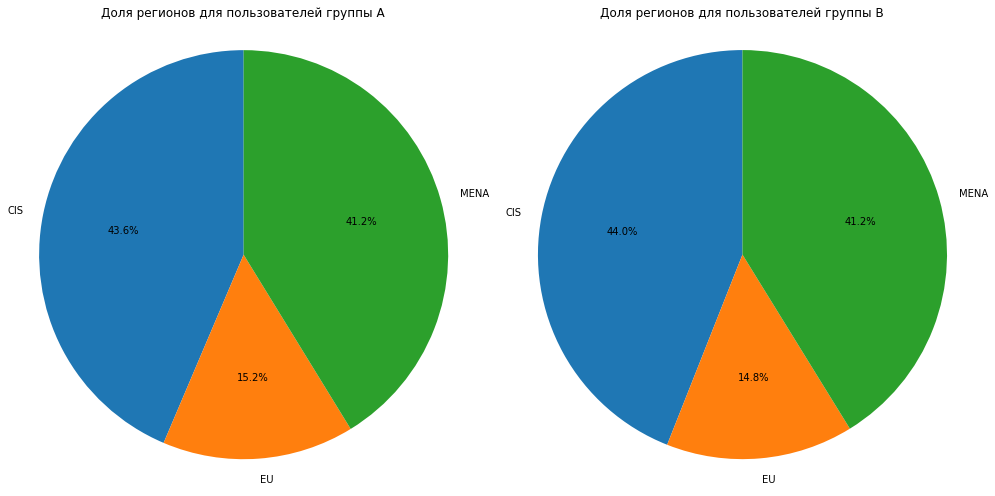

In [20]:
# Группируем данные по region и test_group, считаем количество уникальных пользователей
region_distribution = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().unstack(fill_value=0)

# Рассчитываем долю пользователей для каждой группы
region_distribution_percentage = region_distribution.div(region_distribution.sum(axis=1), axis=0)

# Построение круговых диаграмм
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Круговая диаграмма для группы A
ax[0].pie(region_distribution_percentage.loc['A'], labels=region_distribution_percentage.columns, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Для равных пропорций
ax[0].set_title('Доля регионов для пользователей группы A')

# Круговая диаграмма для группы B
ax[1].pie(region_distribution_percentage.loc['B'], labels=region_distribution_percentage.columns, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Для равных пропорций
ax[1].set_title('Доля регионов для пользователей группы B')

plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

Рассчитанная длительность A/B-теста в 1000 пользователей в день составит 18 дней. Количество уникальных пользователей в группе A: 1477
Количество уникальных пользователей в группе B: 1466
Процентная разница в количестве пользователей между группами A и B: 0.74% . Пользователи между группами A и B не  пересекаются, то есть каждый уникальный пользователь распределен в определнной группе (А или В).ользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.
Пользователи обоих групп равномерно распределены по всем доступным категориальным переменным — типам устройства. По устройствам доминирует тип устройства Андроид в более 0,4, РС около 0,2,  IPhоne 0,2 (чуть больше в группе А), Мас 0,1 (чуть больше в группе В)

Пользователи обоих групп не равномерно распределены по всем доступным категориальным переменным — регионам. Доля каждого региона для пользователей из группы A: максимальная - 43,7% - CIS, 40,85 МЕТА, 15.5% - UE.
Иное распределение доли каждого региона для пользователей из группы В: максимальная - 39.6% -UE, 46,9% -  МЕТА, 13.5% -CIS.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [21]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
# Добавляем столбец good_session на основе conditions
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)
display(sessions_test)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [22]:
# Группировка по дате и тестовой группе, подсчет уникальных
unique_sessions_per = (
    sessions_test.groupby(['session_date', 'test_group'])['session_id']
    .nunique()
    .reset_index()
)

# Разделяем данные по тестовым группам
group_a = unique_sessions_per[unique_sessions_per['test_group'] == 'A']['session_id']
group_b = unique_sessions_per[unique_sessions_per['test_group'] == 'B']['session_id']

# Выполняем t-тест для проверки равенства средних значений двух выборок
t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=False)  

# Выводим p-value
print(f'p-value: {p_value}')

# Интерпретация p-value
alpha = 0.05  
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: существует статистически значимое различие между группами.")
else:
    print("Не отвергаем нулевую гипотезу: различия между группами статистически не значимы.")

p-value: 0.9382195854082714
Не отвергаем нулевую гипотезу: различия между группами статистически не значимы.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [23]:
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]

success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]

dola_a = success_a*100 /(total_a)
dola_b = success_b*100 /(total_b)

#Находим разницу между между долями
dola_a_b = round((dola_b - dola_a), 1) 

# Выводим результаты
print(f'Доля успешных сессий для выборки A составляет: {dola_a:.2f}')
print(f'Доля успешных сессий для выборки B составляет: {dola_b:.2f}')
print(f'Разница в доле успешных сессий между A и B составляет: {dola_a_b:.2f}')

Доля успешных сессий для выборки A составляет: 30.77
Доля успешных сессий для выборки B составляет: 31.83
Разница в доле успешных сессий между A и B составляет: 1.10


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [24]:
# Подсчет уникальных пользователей в группах A и B
n_a = sessions_test[sessions_test.test_group == 'A'].shape[0]   # Уникальные пользователи в группе A
n_b = sessions_test[sessions_test.test_group == 'B'].shape[0]   # Уникальные пользователи в группе B

# Подсчет успешных сессий в группах A и B
m_a = sessions_test[sessions_test.test_group == 'A']['good_session'].sum()  # Количество успехов в группе A
m_b = sessions_test[sessions_test.test_group == 'B']['good_session'].sum()  # Количество успехов в группе B

# Выводим результаты подсчетов для отладки
print(f"Уникальные пользователи A: {n_a}, Успешные сессии A: {m_a}")
print(f"Уникальные пользователи B: {n_b}, Успешные сессии B: {m_b}")

alpha = 0.05  # Уровень значимости

# Проведение Z-теста
if m_a > 0 and m_b > 0:  # Проверка на наличие успехов в обеих группах
    stat_ztest, p_value_ztest = proportions_ztest(
        [m_a, m_b],  # Количество успешных сессий
        [n_a, n_b],  # Общее количество уникальных пользователей
        alternative='two-sided'
    )
    
    # Вывод p-value
    print(f'p-value: {p_value_ztest:.4f}')

    if p_value_ztest > alpha:
        print(f'p-value={p_value_ztest:.4f} > {alpha}')
        print('Нулевая гипотеза находит подтверждение!')
    else:
        print(f'p-value={p_value_ztest:.4f} < {alpha}')
        print('Нулевая гипотеза не находит подтверждения!')
else:
    print("Ошибка: В одной из групп нет успешных сессий. Проведение Z-теста невозможно.")

Уникальные пользователи A: 49551, Успешные сессии A: 15248
Уникальные пользователи B: 50454, Успешные сессии B: 16059
p-value: 0.0003
p-value=0.0003 < 0.05
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

Рассчитанная длительность A/B-теста в 1000 пользователей в день составит 18 дней. Количество уникальных пользователей в группе A: 1477
Количество уникальных пользователей в группе B: 1466
p-value: 0.9. Pазличия между группами статистически не значимы.
Процентная разница в количестве пользователей между группами A и B: 0.74% . Пользователи между группами A и B не  пересекаются, то есть каждый уникальный пользователь распределен в определнной группе (А или В).ользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.
Пользователи обоих групп равномерно распределены по всем доступным категориальным переменным — типам устройства. По устройствам доминирует тип устройства Андроид в более 0,4, РС около 0,2,  IPhоne 0,2 (чуть больше в группе А), Мас 0,1 (чуть больше в группе В)

Пользователи обоих групп не равномерно распределены по всем доступным категориальным переменным — регионам. Доля каждого региона для пользователей из группы A: максимальная - 43,7% - CIS, 40,85 МЕТА, 15.5% - UE.
Иное распределение доли каждого региона для пользователей из группы В: максимальная - 39.6% -UE, 46,9% -  МЕТА, 13.5% -CIS.
Нулевая гипотеза не нашла подтверждение